# CBF Data Exploration (Time Point 1)

## Graph Theory Exploration of TBI & Control Patients from BrainSport CBF Data Set 

Note: Examining only BN Atlas 264 ROIs, using Fisher's Z-value correlation values extracted in CONN Toolbox from processed rsfMRI images for all patients. 


## Table of Contents

<a href = #load>1. Load Data</a>

In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.io import loadmat

<a id = 'load'></a>
## Load Data

In [2]:
#Load in weighted adjacency matrices for ROI-ROI correlations for each participant
data = loadmat('data/T1_Corrs.mat')

#Load in list of ROIs (corresponds to indices/columns in adjacency matrices)
ROIs = loadmat('data/T1_Rois.mat')

In [3]:
#load in covariates for grouping
covariates = pd.read_csv('data/Covariates_AllSubjects.csv')
covariates.head(15)

#grab only relevant columns
#could also grab control.insport and control.nc later
covariates = covariates[['conn.sub.num', 'cohort', 'mTBI', 'control.pooled', 'female', 'male', 'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)']]

#clean up a bit
covariates.head(15)
covariates.rename(inplace = True, columns = {'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)' : 'Ex ROI_Pair'})

#grab only patients which were present for T1
covariates.info()
t1_covariates = covariates.dropna(inplace = False).copy()
t1_covariates.info()

#success!
#no longer need the ex ROI pair (just used to determine patients who did not complete their scan)
t1_covariates.drop(axis=1, inplace=True, labels = 'Ex ROI_Pair')

display(t1_covariates.head(5))
display(t1_covariates.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   conn.sub.num    106 non-null    int64  
 1   cohort          106 non-null    int64  
 2   mTBI            106 non-null    int64  
 3   control.pooled  106 non-null    int64  
 4   female          106 non-null    int64  
 5   male            106 non-null    int64  
 6   Ex ROI_Pair     104 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 5.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 105
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   conn.sub.num    104 non-null    int64  
 1   cohort          104 non-null    int64  
 2   mTBI            104 non-null    int64  
 3   control.pooled  104 non-null    int64  
 4   female          104 non-null    int64  
 5   male            1

,conn.sub.num,cohort,mTBI,control.pooled,female,male
0,1,1,1,0,0,1
1,2,1,1,0,0,1
2,3,1,1,0,0,1
3,4,1,1,0,0,1
4,5,1,1,0,0,1


,conn.sub.num,cohort,mTBI,control.pooled,female,male
101,102,5,0,1,1,0
102,103,5,0,1,1,0
103,104,5,0,1,1,0
104,105,5,0,1,1,0
105,106,5,0,1,1,0


array([[<AxesSubplot:title={'center':'conn.sub.num'}>,
        <AxesSubplot:title={'center':'cohort'}>],
       [<AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'control.pooled'}>],
       [<AxesSubplot:title={'center':'female'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

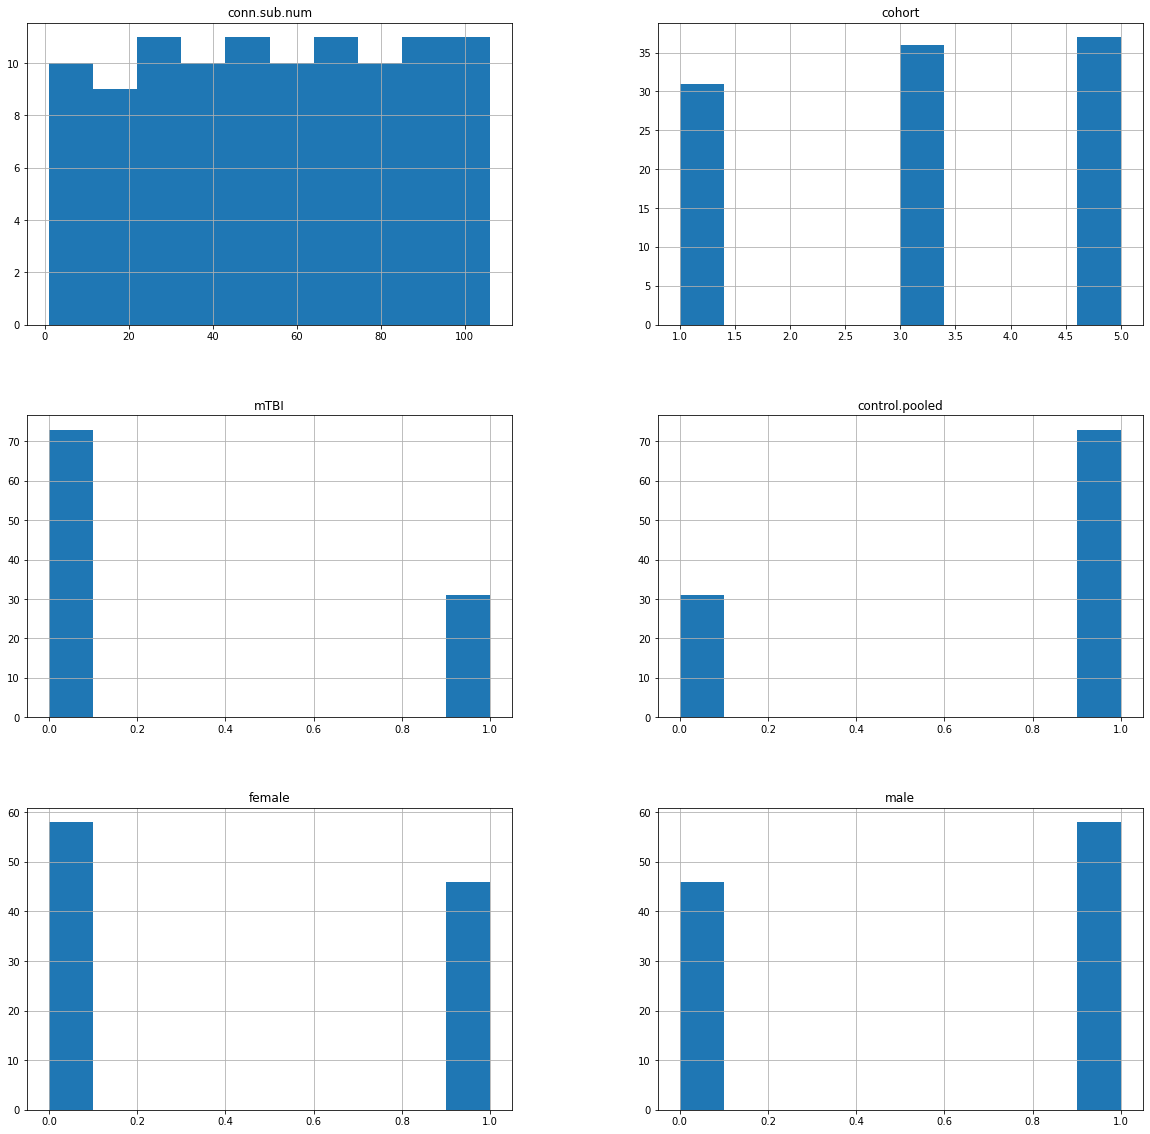

In [4]:
#make figure bigger
plt.rcParams['figure.figsize'] = 20,20

t1_covariates.hist()

Notably, even though I'm working with Fisher's Z Values, the example ROI pair I chose is not normally distributed/ centered around 0. Not important yet, but later it may be important that the dataset is notably imbalanced between TBI and non-TBI (fewer TBI). Will need to use some sort of oversampling/undersampling or utilize metrics which penalize classification errors across both groups treated as positive group. 

In [5]:
ROIs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ROIS'])

In [6]:
%load_ext autoreload
%autoreload 2

import sys
#print(sys.path)
#sys.path.append('/Users/danielfrees/Desktop/brainSPORT_Code/TBI_Graph_Proj/scripts/')
from graph_scripts.Load_Data import load_mats


In [7]:
mats = load_mats(data, ROIs)

Shape of passed ROI-ROI matrix data is: (270, 270, 104)
Number of ROI indices passed is: (1, 270)
All matrices filtered for '264' labeled atlas ROIs only. Shape of each participant matrix is (264, 264).


In [8]:
display(mats[0])

,BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),...,BN_Atlas_264_2mm_wkbrois.L_SI,BN_Atlas_264_2mm_wkbrois.R_SI,BN_Atlas_264_2mm_wkbrois.L_MB,BN_Atlas_264_2mm_wkbrois.R_MB,BN_Atlas_264_2mm_wkbrois.L_SN,BN_Atlas_264_2mm_wkbrois.R_SN,BN_Atlas_264_2mm_wkbrois.L_VTA,BN_Atlas_264_2mm_wkbrois.R_VTA,BN_Atlas_264_2mm_wkbrois.L_PAG,BN_Atlas_264_2mm_wkbrois.R_PAG
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),0.000000,0.517081,0.424918,0.267777,-0.146196,-0.066125,0.191596,0.122094,-0.060311,0.013341,...,0.426904,0.158339,0.020562,-0.092456,-0.066255,-0.088352,-0.297445,-0.241224,-0.155110,-0.070190
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),0.517081,0.000000,0.225464,0.458162,-0.210871,-0.056273,0.083259,0.149250,-0.088856,0.064346,...,0.408473,0.491411,-0.502690,-0.468263,-0.076935,0.277920,-0.299275,-0.174648,0.063503,0.090782
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),0.424918,0.225464,0.000000,0.183562,-0.165810,0.002523,0.081704,-0.016103,-0.091708,0.057501,...,0.160203,0.102249,-0.003709,-0.040740,-0.015249,-0.098627,-0.070257,-0.174450,0.093244,0.106578
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),0.267777,0.458162,0.183562,0.000000,-0.269520,-0.106673,0.220805,0.056635,-0.011687,0.067724,...,0.310277,0.346879,-0.176521,-0.206410,0.014245,0.196668,-0.060560,0.000929,0.170783,0.205802
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),-0.146196,-0.210871,-0.165810,-0.269520,0.000000,0.761407,0.061662,0.000073,0.429212,0.096337,...,-0.106996,-0.191820,-0.120867,-0.083653,-0.006780,-0.099435,-0.077997,-0.099778,-0.163211,-0.221664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BN_Atlas_264_2mm_wkbrois.R_SN,-0.088352,0.277920,-0.098627,0.196668,-0.099435,0.177696,-0.117204,0.010257,-0.028155,0.132656,...,0.348492,0.369691,0.001705,0.023510,0.185769,0.000000,0.283324,0.535693,0.377145,0.452886
BN_Atlas_264_2mm_wkbrois.L_VTA,-0.297445,-0.299275,-0.070257,-0.060560,-0.077997,-0.046352,-0.079691,-0.034843,-0.011959,-0.054250,...,0.018801,-0.037997,0.365764,0.367094,0.582002,0.283324,0.000000,1.315148,0.304628,0.248427
BN_Atlas_264_2mm_wkbrois.R_VTA,-0.241224,-0.174648,-0.174450,0.000929,-0.099778,0.052708,-0.082784,0.029561,-0.033962,0.042231,...,0.048005,0.031978,0.411585,0.471408,0.332022,0.535693,1.315148,0.000000,0.312353,0.270231
BN_Atlas_264_2mm_wkbrois.L_PAG,-0.155110,0.063503,0.093244,0.170783,-0.163211,-0.176924,-0.149700,-0.213432,-0.009079,-0.132656,...,0.147352,0.321298,-0.186501,-0.178901,0.090727,0.377145,0.304628,0.312353,0.000000,1.598811


In [9]:
#TODO: Not working at the moment + Too computationally expensive

#from networkx, I modified for weighted shortest paths -> weighted global efficiency
def global_efficiency(G):
    """Returns the average global efficiency of the graph.

    The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. The *average
    global efficiency* of a graph is the average efficiency of all pairs of
    nodes [1]_.

    """
    n = len(G)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_shortest_path_length(G, weight = 'weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
        # g_eff = sum(1 / d for s, tgts in lengths
        #                   for t, d in tgts.items() if d > 0) / denom
    else:
        g_eff = 0
    # TODO This can be made more efficient by computing all pairs shortest
    # path lengths in parallel.
    return g_eff


In [10]:
#TODO: need to figure out how do these weighted
#print("Avg Local Efficiency: " + str(nx.local_efficiency(p1, weight = 'weight')))
#print("Avg Global Efficiency: " + str(global_efficiency(p1)))

In [11]:
def zero_negatives(val):
    if val<0:
        val=0
    return val

In [12]:
def process_negative_corrs(mats, method = 'zero'):
    if method == 'zero':
        for i in range(len(mats)):
            mats[i] = mats[i].applymap(zero_negatives)
    return mats
        

In [13]:
mats = process_negative_corrs(mats)
mats[0].head(15)

,BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),...,BN_Atlas_264_2mm_wkbrois.L_SI,BN_Atlas_264_2mm_wkbrois.R_SI,BN_Atlas_264_2mm_wkbrois.L_MB,BN_Atlas_264_2mm_wkbrois.R_MB,BN_Atlas_264_2mm_wkbrois.L_SN,BN_Atlas_264_2mm_wkbrois.R_SN,BN_Atlas_264_2mm_wkbrois.L_VTA,BN_Atlas_264_2mm_wkbrois.R_VTA,BN_Atlas_264_2mm_wkbrois.L_PAG,BN_Atlas_264_2mm_wkbrois.R_PAG
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),0.000000,0.517081,0.424918,0.267777,0.000000,0.000000,0.191596,0.122094,0.000000,0.013341,...,0.426904,0.158339,0.020562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),0.517081,0.000000,0.225464,0.458162,0.000000,0.000000,0.083259,0.149250,0.000000,0.064346,...,0.408473,0.491411,0.000000,0.000000,0.000000,0.277920,0.000000,0.000000,0.063503,0.090782
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),0.424918,0.225464,0.000000,0.183562,0.000000,0.002523,0.081704,0.000000,0.000000,0.057501,...,0.160203,0.102249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.093244,0.106578
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),0.267777,0.458162,0.183562,0.000000,0.000000,0.000000,0.220805,0.056635,0.000000,0.067724,...,0.310277,0.346879,0.000000,0.000000,0.014245,0.196668,0.000000,0.000929,0.170783,0.205802
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),0.000000,0.000000,0.000000,0.000000,0.000000,0.761407,0.061662,0.000073,0.429212,0.096337,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),0.000000,0.000000,0.002523,0.000000,0.761407,0.000000,0.000000,0.397069,0.126167,0.643658,...,0.018865,0.000000,0.061506,0.178621,0.000000,0.177696,0.000000,0.052708,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),0.191596,0.083259,0.081704,0.220805,0.061662,0.000000,0.000000,0.000000,0.584579,0.035624,...,0.107848,0.136172,0.000000,0.000000,0.091930,0.000000,0.000000,0.000000,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),0.122094,0.149250,0.000000,0.056635,0.000073,0.397069,0.000000,0.000000,0.000000,0.476063,...,0.000000,0.000000,0.088855,0.193326,0.035714,0.010257,0.000000,0.029561,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),0.000000,0.000000,0.000000,0.000000,0.429212,0.126167,0.584579,0.000000,0.000000,0.210843,...,0.114607,0.125505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),0.013341,0.064346,0.057501,0.067724,0.096337,0.643658,0.035624,0.476063,0.210843,0.000000,...,0.083199,0.007432,0.134627,0.178620,0.000000,0.132656,0.000000,0.042231,0.000000,0.000000


In [14]:
def pass_through_cutoff(val, cutoff):
    if val < cutoff:
        val = 0
    return val

In [15]:
def dynamic_threshold(mat, percentile = 75):
    '''Dynamically threshold Fisher's Z values so that only the specified 
    percentile and up of correlation values are retained. This gives all graphs a density of 
    1-percentile.

    Expects a matrix with negative correlations already removed. Supported by current rsfMRI GT Literature.'''
    arr = mat.values
    cutoff = np.percentile(arr, 75)
    for col in mat.columns:
        mat[col] = mat[col].apply(pass_through_cutoff, args = [cutoff])
    return mat

In [16]:
def threshold_all_mats(mats, percentile):
    for i in range(len(mats)):
        mats[i] = dynamic_threshold(mats[i], percentile)
    return mats

In [17]:
mats = threshold_all_mats(mats, 75)

In [18]:
mats[0].head(10)

,BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),...,BN_Atlas_264_2mm_wkbrois.L_SI,BN_Atlas_264_2mm_wkbrois.R_SI,BN_Atlas_264_2mm_wkbrois.L_MB,BN_Atlas_264_2mm_wkbrois.R_MB,BN_Atlas_264_2mm_wkbrois.L_SN,BN_Atlas_264_2mm_wkbrois.R_SN,BN_Atlas_264_2mm_wkbrois.L_VTA,BN_Atlas_264_2mm_wkbrois.R_VTA,BN_Atlas_264_2mm_wkbrois.L_PAG,BN_Atlas_264_2mm_wkbrois.R_PAG
BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),0.000000,0.517081,0.424918,0.267777,0.000000,0.000000,0.191596,0.000000,0.000000,0.000000,...,0.426904,0.158339,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),0.517081,0.000000,0.225464,0.458162,0.000000,0.000000,0.000000,0.149250,0.000000,0.000000,...,0.408473,0.491411,0.0,0.000000,0.0,0.277920,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),0.424918,0.225464,0.000000,0.183562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.160203,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),0.267777,0.458162,0.183562,0.000000,0.000000,0.000000,0.220805,0.000000,0.000000,0.000000,...,0.310277,0.346879,0.0,0.000000,0.0,0.196668,0.0,0.0,0.170783,0.205802
BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),0.000000,0.000000,0.000000,0.000000,0.000000,0.761407,0.000000,0.000000,0.429212,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),0.000000,0.000000,0.000000,0.000000,0.761407,0.000000,0.000000,0.397069,0.000000,0.643658,...,0.000000,0.000000,0.0,0.178621,0.0,0.177696,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),0.191596,0.000000,0.000000,0.220805,0.000000,0.000000,0.000000,0.000000,0.584579,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),0.000000,0.149250,0.000000,0.000000,0.000000,0.397069,0.000000,0.000000,0.000000,0.476063,...,0.000000,0.000000,0.0,0.193326,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),0.000000,0.000000,0.000000,0.000000,0.429212,0.000000,0.584579,0.000000,0.000000,0.210843,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),0.000000,0.000000,0.000000,0.000000,0.000000,0.643658,0.000000,0.476063,0.210843,0.000000,...,0.000000,0.000000,0.0,0.178620,0.0,0.000000,0.0,0.0,0.000000,0.000000


Avg Clustering: 0.08309838360228661


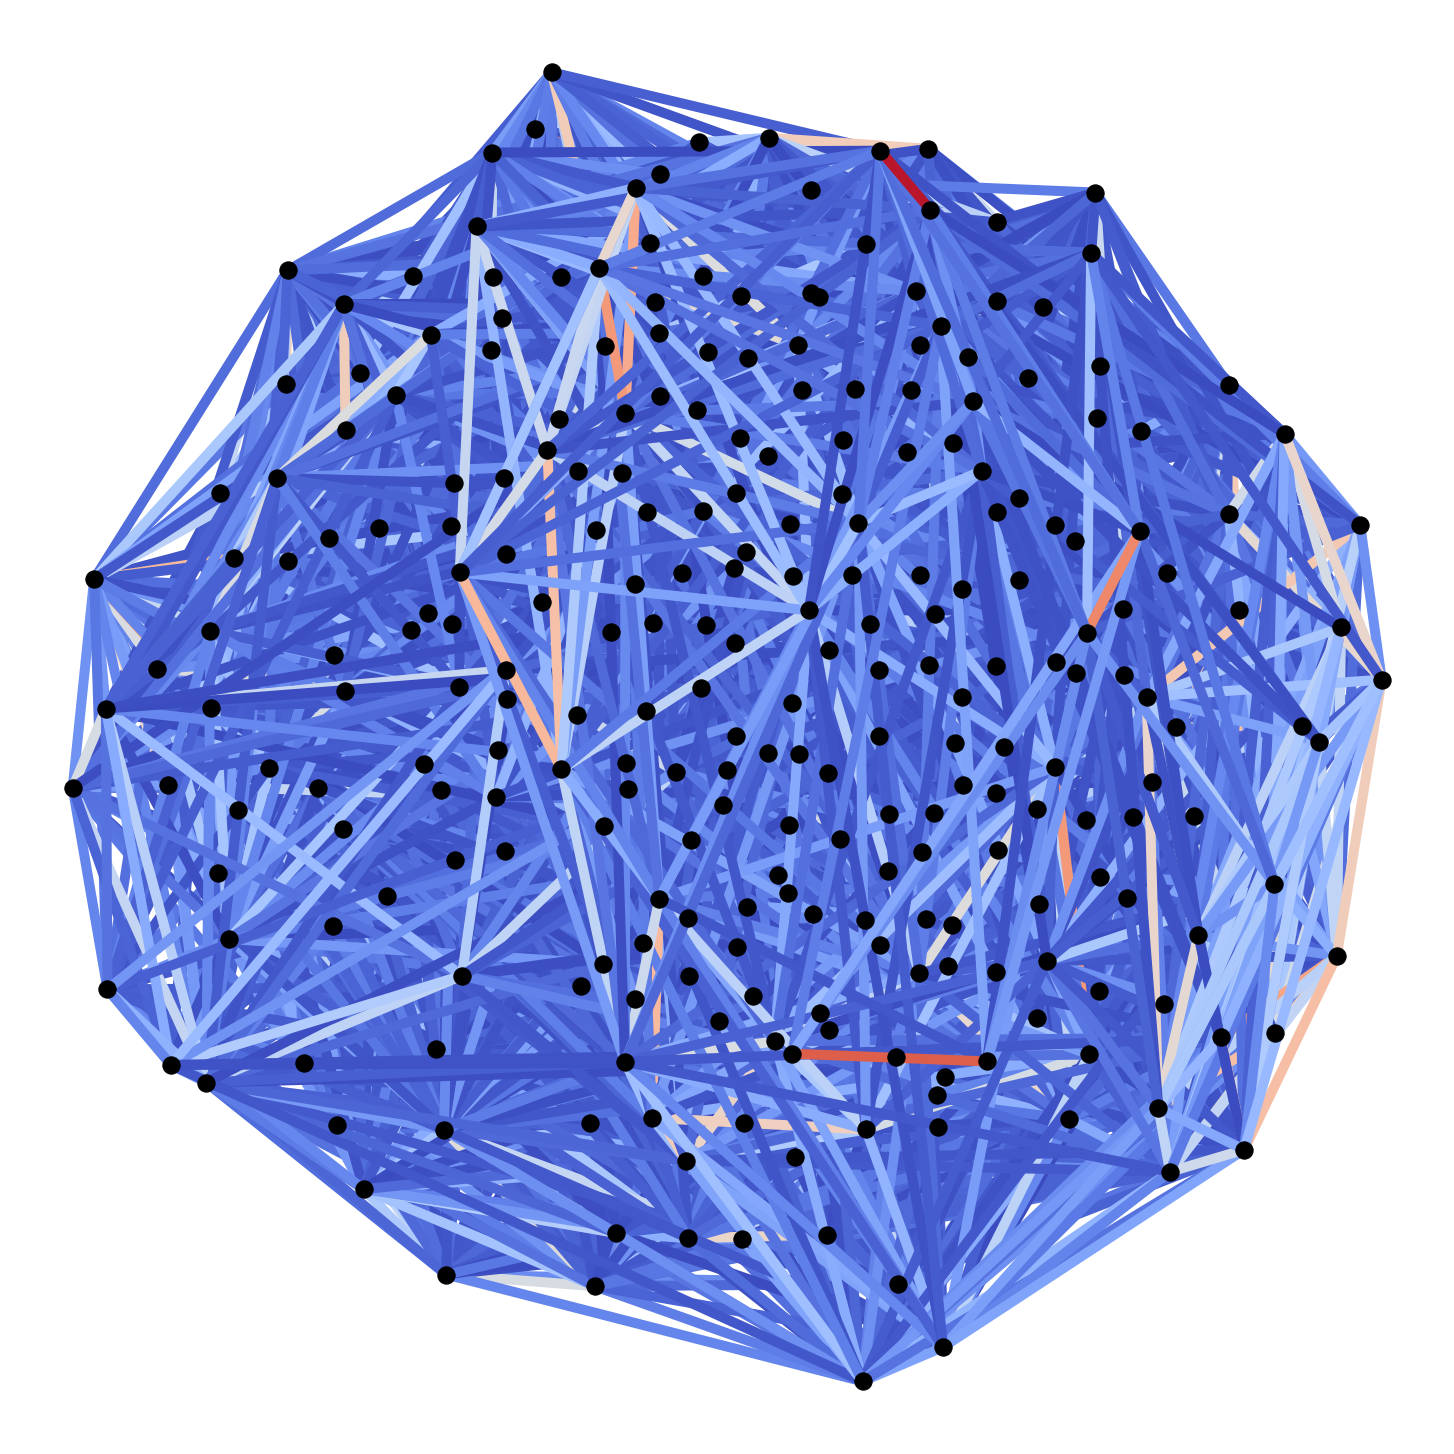

In [19]:
#Investigate participant 1 in detail

p1 = nx.from_pandas_adjacency(mats[0])
p1.name = 'participant_1'

edges,weights = zip(*nx.get_edge_attributes(p1,'weight').items())
pos = nx.spring_layout(p1)
nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

print("Avg Clustering: " + str(nx.average_clustering(p1, weight = 'weight')))



In [20]:
#unhash to see node names (they match the ROIs given)
#p1.nodes

In [21]:
#Investigate Amygdala Nodes (Nodal Degree)

nodes_of_interest = ['BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)', 'BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)', \
                     'BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)', 'BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)', \
                    'BN_Atlas_264_2mm_wkbrois.L_dAmy', 'BN_Atlas_264_2mm_wkbrois.R_dAmy', 'BN_Atlas_264_2mm_wkbrois.L_mAmy' \
                    'BN_Atlas_264_2mm_wkbrois.R_mAmy', 'BN_Atlas_264_2mm_wkbrois.L_vlAmy', 'BN_Atlas_264_2mm_wkbrois.R_vlAmy']
p1.degree(nbunch = nodes_of_interest)

DegreeView({'BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)': 60, 'BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)': 55, 'BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)': 58, 'BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)': 46, 'BN_Atlas_264_2mm_wkbrois.L_dAmy': 71, 'BN_Atlas_264_2mm_wkbrois.R_dAmy': 60, 'BN_Atlas_264_2mm_wkbrois.L_vlAmy': 67, 'BN_Atlas_264_2mm_wkbrois.R_vlAmy': 63})

In [22]:
for node in p1.nodes:
    if 'Amy' in node:
        print(node)

BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)
BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)
BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)
BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)
BN_Atlas_264_2mm_wkbrois.L_dAmy
BN_Atlas_264_2mm_wkbrois.R_dAmy
BN_Atlas_264_2mm_wkbrois.L_mAmy
BN_Atlas_264_2mm_wkbrois.R_mAmy
BN_Atlas_264_2mm_wkbrois.L_vlAmy
BN_Atlas_264_2mm_wkbrois.R_vlAmy


In [23]:
#Investigate Amygdala Nodes (Nodal Strength)

p1.degree(weight = 'weight', nbunch = nodes_of_interest)

DegreeView({'BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala)': 16.764669885551925, 'BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala)': 15.172976223788561, 'BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala)': 15.480157515848322, 'BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala)': 13.011417882513465, 'BN_Atlas_264_2mm_wkbrois.L_dAmy': 21.693333945135155, 'BN_Atlas_264_2mm_wkbrois.R_dAmy': 20.24736649080644, 'BN_Atlas_264_2mm_wkbrois.L_vlAmy': 19.814593215529705, 'BN_Atlas_264_2mm_wkbrois.R_vlAmy': 20.261907212813913})

In [24]:
#Investigate shortest unweighted path between Amygdala Nodes and 

this_to_LMB = nx.shortest_path_length(p1,'BN_Atlas_264_2mm_wkbrois.L_dAmy', 'BN_Atlas_264_2mm_wkbrois.L_MB')
this_to_RMB = nx.shortest_path_length(p1,'BN_Atlas_264_2mm_wkbrois.L_dAmy', 'BN_Atlas_264_2mm_wkbrois.R_MB')
print(this_to_LMB)
print(this_to_RMB)

2
2


In [25]:
len(mats)

104

In [26]:
#Covariates correct for this time point

len(t1_covariates)

104

In [27]:
#Look at type of Covariate this Mat Corresponds to 
cov = t1_covariates.loc[0,:]
cov

conn.sub.num      1
cohort            1
mTBI              1
control.pooled    0
female            0
male              1
Name: 0, dtype: int64

In [28]:
#Characteristic Path Length of graph (average unweighted shortest path length )
#This may become more interesting with some thresholding

UW_CPL = nx.average_shortest_path_length(p1)
UW_CPL

1.7627318815531743